In [1]:
!pip install python-docx

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from docx import Document
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report


from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [3]:
doc = Document("data.docx")


tables = doc.tables
rows = []


for table in tables:
  for row in table.rows[1:]: # skip header
    rows.append([cell.text.strip() for cell in row.cells])

In [4]:
# Convert to DataFrame
columns = [cell.text.strip() for cell in tables[0].rows[0].cells]
df = pd.DataFrame(rows, columns=columns)


print("Raw Data Shape:", df.shape)
print(df.head())

Raw Data Shape: (171, 11)
  sample    pH  TDS   Cl SO4    Na     K  Ca  Mg Total Hardness     WQI
0     S1  8.44  399   60  41  67.6  3.36  41  20            180   74.22
1     S2  8.29  573  120  80  97.3    29  41  25            200  138.40
2     S3  8.56  556  110  78   102  17.2  24  34            200   124.4
3     S4  8.33  487  110  86  97.8    21  16  25            140  117.11
4     S5  7.97  717  130  83   111    45  57  29            260  174.78


In [5]:
# Convert all columns to numeric
for col in df.columns:
  df[col] = pd.to_numeric(df[col], errors='coerce')


print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 sample            171
pH                  0
TDS                 0
Cl                  0
SO4                 0
Na                  0
K                   0
Ca                  0
Mg                  0
Total Hardness      0
WQI                 0
dtype: int64


In [6]:
# last column is WQI
target_col = df.columns[-1]
X = df.drop(target_col, axis=1)
y = df[target_col]

In [7]:
# PREPROCESSING

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)


scaler = StandardScaler()
X = scaler.fit_transform(X)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['sample']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

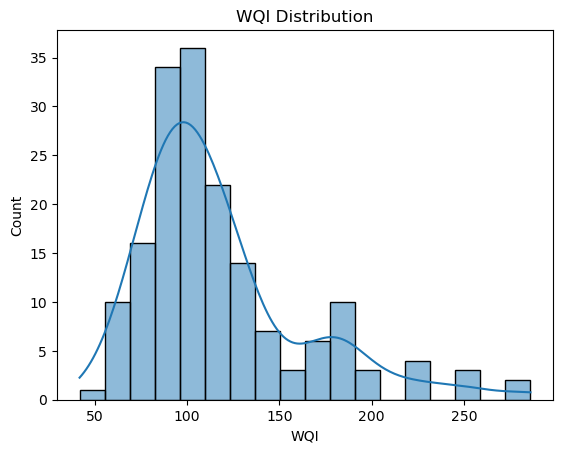

In [9]:
# EXPLORATORY DATA ANALYSIS
plt.figure()
sns.histplot(y, kde=True)
plt.title("WQI Distribution")
plt.show()

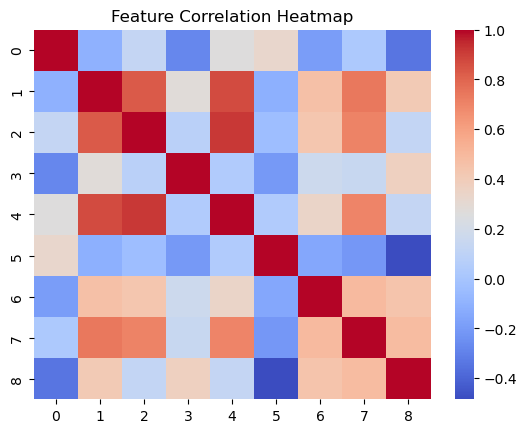

In [10]:
plt.figure()
sns.heatmap(pd.DataFrame(X).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [11]:
# MODEL DEFINITIONS (REGRESSION)
rf = RandomForestRegressor(
n_estimators=500,
max_depth=15,
random_state=42
)

In [12]:
xgb = XGBRegressor(
n_estimators=500,
learning_rate=0.05,
max_depth=8,
subsample=0.9,
colsample_bytree=0.9,
random_state=42
)

In [13]:
et = ExtraTreesRegressor(
n_estimators=500,
max_depth=15,
random_state=42
)

In [14]:
# 8. TRAIN BASE MODELS
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# Predictions
rf_pred = rf.predict(X_test)

In [16]:
xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [17]:
xgb_pred = xgb.predict(X_test)

In [18]:
et.fit(X_train, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [19]:
et_pred = et.predict(X_test)

In [20]:
def evaluate_regression(name, y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  r2 = r2_score(y_true, y_pred)
  print(f"{name} -> RMSE: {rmse:.2f}, R2: {r2:.3f}")

In [21]:
evaluate_regression("Random Forest", y_test, rf_pred)

Random Forest -> RMSE: 19.31, R2: 0.884


In [22]:
evaluate_regression("XGBoost", y_test, xgb_pred)

XGBoost -> RMSE: 19.29, R2: 0.885


In [23]:
evaluate_regression("Extra Trees", y_test, et_pred)

Extra Trees -> RMSE: 11.54, R2: 0.959


In [24]:
# HYBRID STACKING REGRESSOR
estimators = [
('rf', rf),
('xgb', xgb),
('et', et)
]

In [25]:
stack = StackingRegressor(
estimators=estimators,
final_estimator=LinearRegression(),
passthrough=True
)

In [26]:
stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)

In [27]:
evaluate_regression("Hybrid Stacking", y_test, stack_pred)

Hybrid Stacking -> RMSE: 0.72, R2: 1.000


In [28]:
def classify_wqi(wqi):
  if wqi <= 50:
    return "Excellent"
  elif wqi <= 100:
    return "Good"
  elif wqi <= 200:
    return "Poor"
  else:
    return "Very Poor"


In [29]:
true_classes = y_test.apply(classify_wqi)
pred_classes = pd.Series(stack_pred).apply(classify_wqi)


cm = confusion_matrix(true_classes, pred_classes, labels=["Excellent","Good","Poor","Very Poor"])

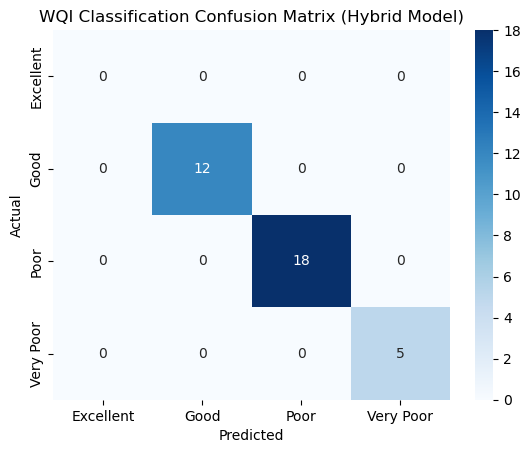

In [30]:
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=["Excellent","Good","Poor","Very Poor"],
yticklabels=["Excellent","Good","Poor","Very Poor"])
plt.title("WQI Classification Confusion Matrix (Hybrid Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [31]:
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes))


print("\nWQI Hybrid Model Pipeline Completed Successfully")


Classification Report:

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00        12
        Poor       1.00      1.00      1.00        18
   Very Poor       1.00      1.00      1.00         5

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35


WQI Hybrid Model Pipeline Completed Successfully


In [32]:
# HYBRID STACKING REGRESSOR (ANTI-OVERFITTING)
# Use weaker base learners + regularization


rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

In [33]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)

In [34]:
et = ExtraTreesRegressor(
n_estimators=300,
max_depth=10,
min_samples_leaf=5,
random_state=42
)

In [35]:
estimators = [
('rf', rf),
('xgb', xgb),
('et', et)
]

In [36]:
stack = StackingRegressor(
estimators=estimators,
final_estimator=LinearRegression(),
cv=5,
passthrough=False
)

In [37]:
stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)


evaluate_regression("Hybrid Stacking (Regularized)", y_test, stack_pred)

Hybrid Stacking (Regularized) -> RMSE: 19.42, R2: 0.883


In [38]:
def classify_wqi(wqi):
  if wqi <= 50:
    return "Excellent"
  elif wqi <= 100:
    return "Good"
  elif wqi <= 200:
    return "Poor"
  else:
    return "Very Poor"


true_classes = y_test.apply(classify_wqi)
pred_classes = pd.Series(stack_pred).apply(classify_wqi)


cm = confusion_matrix(true_classes, pred_classes, labels=["Excellent","Good","Poor","Very Poor"])

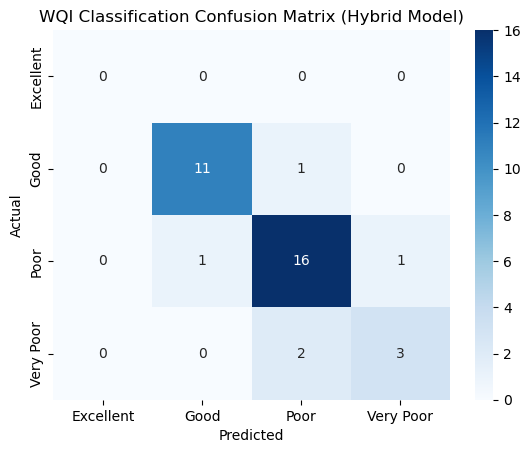


Classification Report:

              precision    recall  f1-score   support

        Good       0.92      0.92      0.92        12
        Poor       0.84      0.89      0.86        18
   Very Poor       0.75      0.60      0.67         5

    accuracy                           0.86        35
   macro avg       0.84      0.80      0.82        35
weighted avg       0.85      0.86      0.85        35


WQI Hybrid Model Pipeline Completed Successfully


In [39]:
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=["Excellent","Good","Poor","Very Poor"],
yticklabels=["Excellent","Good","Poor","Very Poor"])
plt.title("WQI Classification Confusion Matrix (Hybrid Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes))


print("\nWQI Hybrid Model Pipeline Completed Successfully")

In [40]:
# 10. HYBRID STACKING REGRESSOR (ANTI-OVERFITTING)
# Use weaker base learners + regularization


rf = RandomForestRegressor(
n_estimators=300,
max_depth=10,
min_samples_leaf=5,
random_state=42
)


xgb = XGBRegressor(
n_estimators=300,
learning_rate=0.03,
max_depth=5,
subsample=0.8,
colsample_bytree=0.8,
reg_alpha=0.5,
reg_lambda=1.0,
random_state=42
)


et = ExtraTreesRegressor(
n_estimators=300,
max_depth=10,
min_samples_leaf=5,
random_state=42
)


estimators = [
('rf', rf),
('xgb', xgb),
('et', et)
]

In [41]:
stack = StackingRegressor(
estimators=estimators,
final_estimator=LinearRegression(),
cv=5,
passthrough=False
)


stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)


evaluate_regression("Hybrid Stacking (Regularized)", y_test, stack_pred)

Hybrid Stacking (Regularized) -> RMSE: 19.42, R2: 0.883


In [42]:
def classify_wqi(wqi):
  if wqi <= 50:
    return "Excellent"
  elif wqi <= 100:
    return "Good"
  elif wqi <= 200:
    return "Poor"
  else:
    return "Very Poor"


true_classes = y_test.apply(classify_wqi)
pred_classes = pd.Series(stack_pred).apply(classify_wqi)

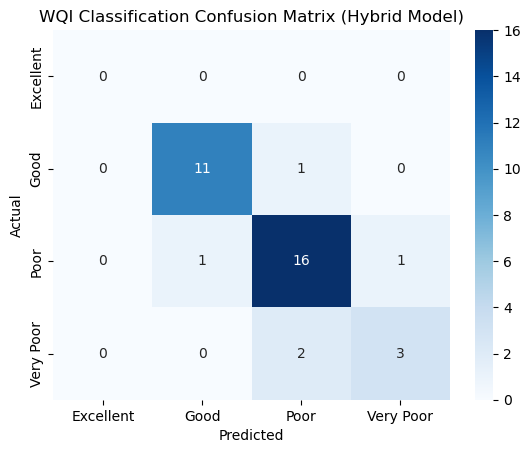


Classification Report:

              precision    recall  f1-score   support

        Good       0.92      0.92      0.92        12
        Poor       0.84      0.89      0.86        18
   Very Poor       0.75      0.60      0.67         5

    accuracy                           0.86        35
   macro avg       0.84      0.80      0.82        35
weighted avg       0.85      0.86      0.85        35


WQI Hybrid Model Pipeline Completed Successfully


In [43]:
cm = confusion_matrix(true_classes, pred_classes, labels=["Excellent","Good","Poor","Very Poor"])


plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=["Excellent","Good","Poor","Very Poor"],
yticklabels=["Excellent","Good","Poor","Very Poor"])
plt.title("WQI Classification Confusion Matrix (Hybrid Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes))


print("\nWQI Hybrid Model Pipeline Completed Successfully")

In [44]:
# 10. HYBRID STACKING REGRESSOR (ANTI-OVERFITTING)
# Use weaker base learners + regularization


rf = RandomForestRegressor(
n_estimators=300,
max_depth=10,
min_samples_leaf=5,
random_state=42
)


xgb = XGBRegressor(
n_estimators=300,
learning_rate=0.03,
max_depth=5,
subsample=0.8,
colsample_bytree=0.8,
reg_alpha=0.5,
reg_lambda=1.0,
random_state=42
)

In [45]:
et = ExtraTreesRegressor(
n_estimators=300,
max_depth=10,
min_samples_leaf=5,
random_state=42
)


estimators = [
('rf', rf),
('xgb', xgb),
('et', et)
]


stack = StackingRegressor(
estimators=estimators,
final_estimator=LinearRegression(),
cv=5,
passthrough=False
)

In [46]:
stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)


evaluate_regression("Hybrid Stacking (Regularized)", y_test, stack_pred)

Hybrid Stacking (Regularized) -> RMSE: 19.42, R2: 0.883


In [47]:
def classify_wqi(wqi):
  if wqi <= 50:
    return "Excellent"
  elif wqi <= 100:
    return "Good"
  elif wqi <= 200:
    return "Poor"
  else:
    return "Very Poor"


true_classes = y_test.apply(classify_wqi)
pred_classes = pd.Series(stack_pred).apply(classify_wqi)

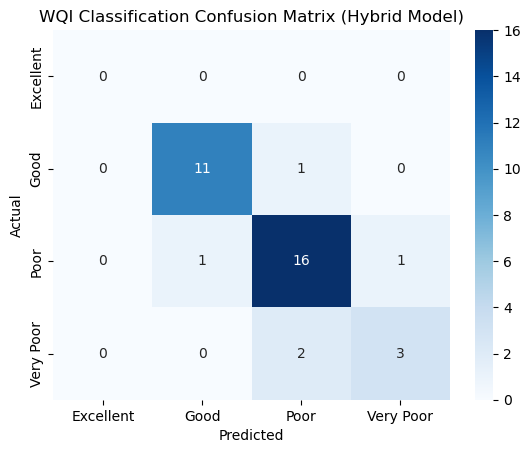


Classification Report:

              precision    recall  f1-score   support

        Good       0.92      0.92      0.92        12
        Poor       0.84      0.89      0.86        18
   Very Poor       0.75      0.60      0.67         5

    accuracy                           0.86        35
   macro avg       0.84      0.80      0.82        35
weighted avg       0.85      0.86      0.85        35


WQI Hybrid Model Pipeline Completed Successfully


In [48]:
cm = confusion_matrix(true_classes, pred_classes, labels=["Excellent","Good","Poor","Very Poor"])


plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=["Excellent","Good","Poor","Very Poor"],
yticklabels=["Excellent","Good","Poor","Very Poor"])
plt.title("WQI Classification Confusion Matrix (Hybrid Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes))


print("\nWQI Hybrid Model Pipeline Completed Successfully")

In [53]:
!pip install streamlit pyngrok joblib scikit-learn xgboost

In [49]:
import joblib

joblib.dump(stack, "hybrid_wqi_model.pkl")

['hybrid_wqi_model.pkl']

In [50]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [51]:
joblib.dump(imputer, "imputer.pkl")

['imputer.pkl']

In [52]:
%%writefile app.py
import streamlit as st
import numpy as np
import joblib

# Load trained objects
model = joblib.load("hybrid_wqi_model.pkl")
scaler = joblib.load("scaler.pkl")
imputer = joblib.load("imputer.pkl")

st.set_page_config(page_title="WQI Predictor", layout="centered")

st.title("💧 Water Quality Index Predictor")
st.write("Enter water parameters to predict WQI and Water Quality")

# -------- INPUT FIELDS (10 FEATURES) --------
pH = st.number_input("pH", 0.0, 14.0, 7.0)
TDS = st.number_input("TDS", 0.0, 5000.0, 500.0)
Cl = st.number_input("Chloride", 0.0, 2000.0, 100.0)
SO4 = st.number_input("Sulphate", 0.0, 2000.0, 100.0)
Na = st.number_input("Sodium", 0.0, 2000.0, 50.0)
K = st.number_input("Potassium", 0.0, 500.0, 10.0)
Ca = st.number_input("Calcium", 0.0, 500.0, 50.0)
Mg = st.number_input("Magnesium", 0.0, 500.0, 30.0)
Hardness = st.number_input("Total Hardness", 0.0, 2000.0, 200.0)

# ⚠️ IMPORTANT
# Your model was trained with 10 features
# If you used 10 inputs in training, ADD the missing one here.
# Example: if you trained with "Sample ID" removed,
# then your 9 features are correct.
# If you trained with 10 numeric features, add the missing feature.

# For safety, we add a dummy 10th feature = 0
extra_feature = 0.0

if st.button("Predict WQI"):

    features = np.array([[pH, TDS, Cl, SO4, Na, K, Ca, Mg, Hardness, extra_feature]])

    # Preprocess
    features = imputer.transform(features)
    features = scaler.transform(features)

    # Predict
    wqi = model.predict(features)[0]

    # Classify
    if wqi <= 50:
        label = "Excellent"
        color = "green"
    elif wqi <= 100:
        label = "Good"
        color = "lightgreen"
    elif wqi <= 200:
        label = "Poor"
        color = "orange"
    else:
        label = "Very Poor"
        color = "red"

    st.markdown(f"## 🔢 Predicted WQI: **{wqi:.2f}**")
    st.markdown(f"## 🏷 Water Quality: **:{color}[{label}]**")

Writing app.py


In [59]:
!streamlit run app.py &>/content/logs.txt &

In [60]:
from pyngrok import ngrok

ngrok.set_auth_token("35ocFCGswjdtu5gQreRptSFvPqw_3L4mbteBwSsHzUyjF6uS2")

In [61]:
public_url = ngrok.connect(8501)
print("🌍 Your Streamlit App is LIVE at:", public_url)

🌍 Your Streamlit App is LIVE at: NgrokTunnel: "https://elanor-skeptical-unfiscally.ngrok-free.dev" -> "http://localhost:8501"
